In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
sys.path.append('../')
from src.data import train_val_test_split
from src.data import get_descriptor_and_labels

In [2]:
use_mda = True
numb_train_samples = 8_000
train_structs, val_structs, test_structs = train_val_test_split(mda=use_mda,num_files=None)

In [3]:
train_x, train_y, label_mapping = get_descriptor_and_labels(train_structs,num_samples_per_type=numb_train_samples)
val_x, val_y, _ = get_descriptor_and_labels(val_structs, num_samples_per_type=2_500)
test_x, test_y, _ = get_descriptor_and_labels(test_structs, num_samples_per_type=2_500)

# need to convert one-hot vectors to integers
train_y = np.argmax(train_y,axis=1)
val_y = np.argmax(val_y,axis=1)
test_y = np.argmax(test_y,axis=1)

In [16]:
label_mapping

{'hda': 0, 'lda': 1, 'mda': 2}

In [5]:
train_ys = []
test_ys = []
for i in range(3):
    train_ys.append(np.where(train_y==i,1,0))
    test_ys.append(np.where(test_y==i,1,0))

In [47]:
# from sklearn.ensemble import RandomForestClassifier
# import pandas as pd
# import matplotlib.pyplot as plt

# %config InlineBackend.figure_format = 'retina'
# plt.style.use('plot.mplstyle')
   
# fig, axs = plt.subplots(3,1,figsize=(5,5))
# model = RandomForestClassifier(random_state=0, n_estimators=300)

# labels = ['HDA','LDA','MDA']
# colors = ['#ffbe0b','#7209b7','#4895ef']

# # train 3 separate models on each class
# for i in range(3):
#     model.fit(train_x,train_ys[i])
#     # print(model.score(test_x,test_ys[i]))
    
#     importances = pd.Series(model.feature_importances_)
#     importances.plot.bar(ax=axs[i],color=colors[i])

# # ax.set_title("Feature importances using MDI")
# # ax.set_ylabel("Mean decrease in impurity")
# fig.tight_layout()
    

In [10]:
import optuna
from sklearn.neural_network import MLPClassifier

study_name = "optimise_NN"  # Unique identifier of the study.
storage_name = f"sqlite:///{study_name}.db"
study = optuna.create_study(study_name=study_name, storage=storage_name, load_if_exists=True)
optimised_NN_params = study.best_params

n_layers, neurons_per_layer, weight_decay, lr = optimised_NN_params.values()
hidden_layers = [neurons_per_layer] * n_layers
input_size = 30
output_size = 3

model = MLPClassifier(hidden_layer_sizes=hidden_layers,activation='relu',solver='adam',batch_size=200,learning_rate_init=lr,alpha=weight_decay,max_iter=1000)

[I 2023-12-13 15:21:11,967] Using an existing study with name 'optimise_NN' instead of creating a new one.


In [50]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.inspection import permutation_importance
# import pandas as pd
# import matplotlib.pyplot as plt

# %config InlineBackend.figure_format = 'retina'
# plt.style.use('plot.mplstyle')

# fig, ax = plt.subplots(1,1,figsize=(8,5))

# model.fit(train_x,train_y)
# print(model.score(test_x,test_y))
# result = permutation_importance(model, test_x, test_y, n_repeats=10, random_state=42)
# importances = pd.Series(result.importances_mean)
# importances.plot.bar(ax=ax)

# ax.set_xticks(np.arange(0,30),list(desc_to_plot_label_mapping.values()),fontsize=8);
# fig.tight_layout()


In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

model = RandomForestClassifier(random_state=0, n_estimators=300)
classification_results = {}
struct_types = ['HDA','LDA','MDA']
for i in range(3):
    model.fit(train_x,train_ys[i])
    print(model.score(test_x,test_ys[i]))
    result = permutation_importance(model, test_x, test_ys[i], n_repeats=10, random_state=42)
    classification_results[struct_types[i]] = result
    print(i)

0.988
0
0.8574666666666667
1
0.8425333333333334
2


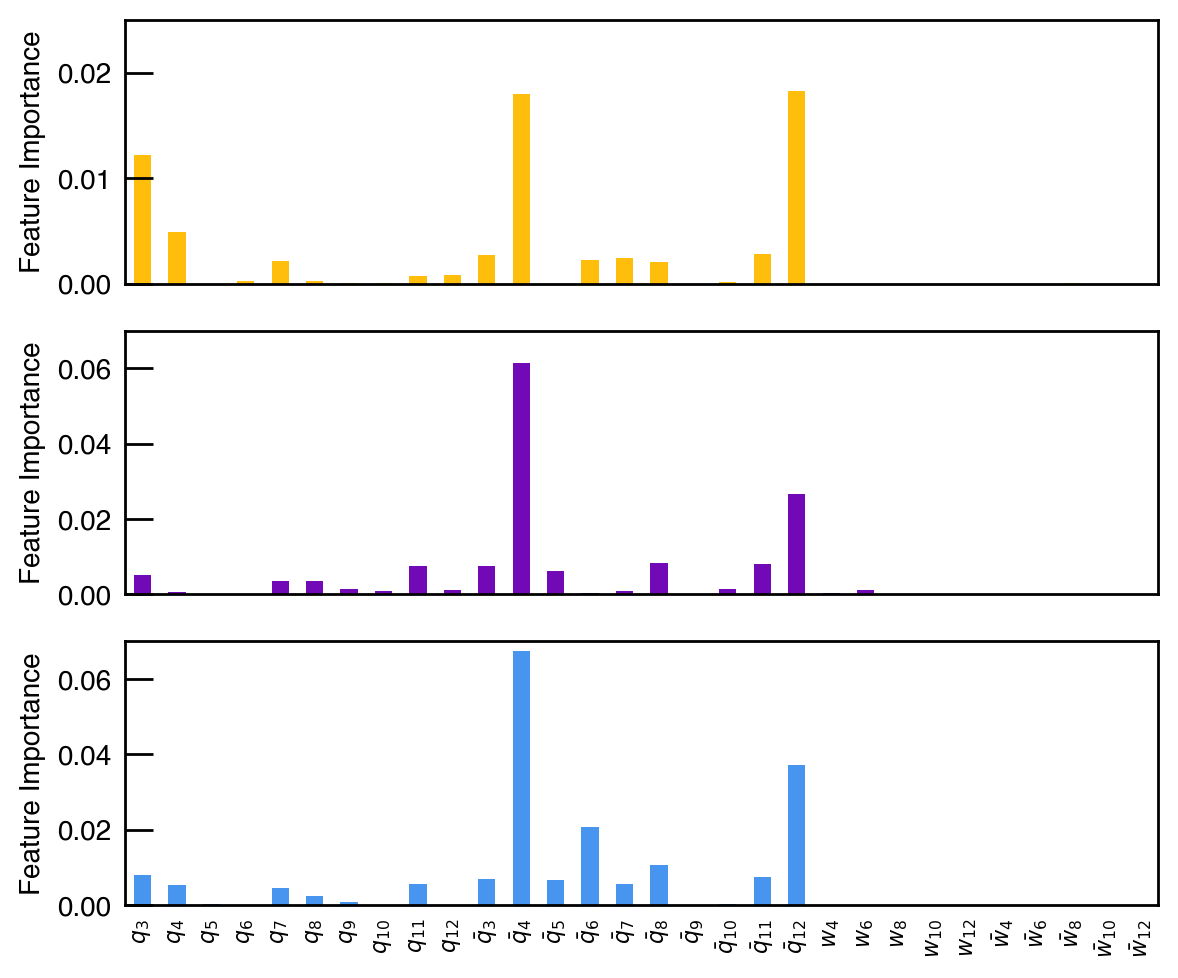

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import sys
sys.path.append('../')
from src.steinhardt import desc_to_plot_label_mapping

%config InlineBackend.figure_format = 'retina'
plt.style.use('plot.mplstyle')

labels = ['HDA','LDA','MDA']
colors = ['#ffbe0b','#7209b7','#4895ef']

fig, axs = plt.subplots(3,1,figsize=(6,5),sharex=True)

for i in range(3):
    result = classification_results[struct_types[i]]
    importances = pd.Series(result.importances_mean)
    importances.plot.bar(ax=axs[i],color=colors[i],label=labels[i])
    # axs[i].legend()
    axs[i].set_ylabel('Feature Importance')   
axs[0].set_ylim(0,0.025)
axs[1].set_ylim(0,0.07)
axs[2].set_ylim(0,0.07)
   
axs[-1].set_xticks(np.arange(0,30),list(desc_to_plot_label_mapping.values()),fontsize=8);
# reduce length of xtick 
for ax in axs:
    ax.tick_params(axis='x', which='major', pad=5, length=0)
    ax.tick_params(axis='y', which='major', pad=5, labelsize=10)
    # change ytick label size
    

# make plot borders thinner
linewidth = 1
for ax in axs:
    ax.spines['top'].set_linewidth(linewidth)
    ax.spines['right'].set_linewidth(linewidth)
    ax.spines['bottom'].set_linewidth(linewidth)
    ax.spines['left'].set_linewidth(linewidth)
    # ax.get_legend().get_frame().set_linewidth(0.0)
    

# remove the box around the legend
fig.tight_layout()
plt.savefig('../figures/feature_importance_RandomForest.svg',dpi=300,bbox_inches='tight')